In [127]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [128]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [129]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [130]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [131]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [132]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [133]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [134]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [135]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(16.7, 20.873214285714287, 23.3)]


In [160]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# You want to take a trip from August 1 to August 7 of this year data set
def stats(start_date='2015-08-01', end_date='2015-08-07'):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()  


# for a year 2015 in the data set
print(stats('2015-08-01', '2015-08-07'))


[(20.6, 25.702272727272728, 29.4)]


8.799999999999997


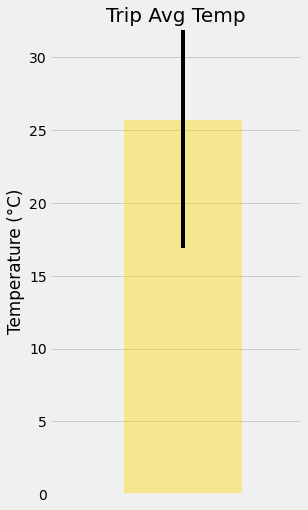

In [163]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Plot variables
from turtle import color


p_to_p = 29.4-20.6
mean_temp_2015 = 25.70
plot_index = 1 

plt.figure(figsize=(4,8))
plt.xticks([])

plt.title("Trip Avg Temp",fontsize=20)
plt.ylabel("Temperature (°C)")
plt.xlim(.10 , 1.8)
plt.ylim(0,32)

plt.bar(plot_index, mean_temp_2015, yerr=p_to_p, color='gold', ecolor="black", align="center", alpha=0.4)

print(p_to_p)

### Daily Rainfall Average

In [158]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Get the stations list
stations = session.query(Station.station)
stations_df = pd.read_sql_query(stations.statement, session.bind)
stations_df.to_dict()


{'station': {0: 'USC00519397',
  1: 'USC00513117',
  2: 'USC00514830',
  3: 'USC00517948',
  4: 'USC00518838',
  5: 'USC00519523',
  6: 'USC00519281',
  7: 'USC00511918',
  8: 'USC00516128'}}

In [170]:
station_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date >= '2015-08-01').\
        filter(Measurement.date <= '2015-08-07').group_by(Measurement.station)

def rain_perstation(name):
        sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
        return session.query(*sel).filter(Station.station == name).first()

In [175]:
stations_records = []
station_list = ['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281','USC00511918', 'USC00516128']

for record in station_list:
    r=rain_perstation(one)
    stations_records.append(r)
    
# show results 
stations_records

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45)]

In [177]:
#create a df of station_results
station_records_df = pd.DataFrame(stations_records)

# create a df of rainfall results
rain_info_df = pd.read_sql_query(station_prcp.statement, session.bind)

rain_info_df.head()

,station,sum_1
0,USC00511918,2.5
1,USC00513117,17.3
2,USC00516128,44.5
3,USC00517948,1.3
4,USC00519281,13.5


In [190]:
# Merge tables & sort this in descending order by precipitation amount, and list the station, name, latitude, longitude, and elevation.

rain_info_df = rain_info_df.rename(columns={'sum_1': 'prec_sum'})
pd.merge(station_records_df, rain_info_df, on="station", how="inner").sort_values(by=["prec_sum"],ascending=False)


,station,name,latitude,longitude,elevation,prec_sum
0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
4,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
5,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
6,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
7,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3
8,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.45,17.3


### Daily Temperature Normals

In [193]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(16.7, 20.64230769230769, 25.0)]

In [196]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

date_range = ['']
result_normals = []


##def stats(start_date='2017-08-01', end_date='2017-08-07'):


data_range_df = pd.DataFrame, session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()

data_range_df

AttributeError: 'tuple' object has no attribute 'dtypes'

In [195]:
# Strip off the year and save a list of strings in the format %m-%d
start = dt.datetime.strptime(start_date, "%m%d")
end = dt.datetime.strptime(end_date, "%m%d")



ValueError: unconverted data remains: 7-08-01

In [ ]:
# Use the `daily_normals` function to calculate the normals for each date string 
def normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# and append the results to a list called `normals`.
normals("01-01")

In [ ]:
# Load the previous query results into a Pandas DataFrame and 


# add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


## Close Session

In [ ]:
session.close()